# WeCLIP

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd())) # to avoid import error with other directories 

In [2]:
from grad_cam.grad_cam import GradCAM
from WeCLIP.WeCLIP_model.Decoder.TransDecoder import DecoderTransformer
from WeCLIP.clip import clip # works pretty much like original CLIP implementation, but returns multi-level features and attention maps
from WeCLIP.datasets.voc import VOC12SegDataset

import torch.nn.functional as F
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage

from PIL import Image
import cv2

import numpy as np
import matplotlib.pyplot as plt

c:\Users\giuse\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## get data

In [3]:
root_dir = r"C:\01_Learning\01_Data_science\01_University\01_UniTrento\01_Classes\Semester\3\Advanced_CV\Code\Advanced-CV-Project\VOCdevkit\VOC2012"
name_list_dir = r"C:\01_Learning\01_Data_science\01_University\01_UniTrento\01_Classes\Semester\3\Advanced_CV\Code\WeCLIP\datasets\voc"

In [4]:
# used in WeCLIP.forward() when generating CAMs
root_path = os.path.join(root_dir, "SegmentationClassAug")
root_path

'C:\\01_Learning\\01_Data_science\\01_University\\01_UniTrento\\01_Classes\\Semester\\3\\Advanced_CV\\Code\\Advanced-CV-Project\\VOCdevkit\\VOC2012\\SegmentationClassAug'

In [5]:
# dataset of segmentations for VOC2012
val_dataset = VOC12SegDataset(
        root_dir=root_dir,
        name_list_dir=name_list_dir,
        split="train",
        stage='train',
        aug=False,
        ignore_index=255,
        num_classes=21,
    )

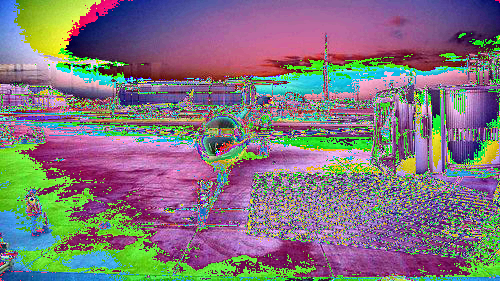

In [6]:
ToPILImage()(torch.tensor(val_dataset[0][1]))

In [7]:
val_loader = DataLoader(val_dataset,
                        batch_size=1,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=False,
                        drop_last=False)

In [8]:
name, inputs, labels, cls_labels = next(iter(val_loader))

In [9]:
# not clear why they do this
_, _, h, w = inputs.shape
ratio = 512 / max(h,w)
_h, _w = int(h*ratio), int(w*ratio)
inputs = F.interpolate(inputs, size=(_h, _w), mode='bilinear', align_corners=False)

In [10]:
segs_list = []
inputs_cat = torch.cat([inputs, inputs.flip(-1)], dim=0)

In [11]:
names = name + name

`segs_cat, cam, attn_loss =  model(inputs_cat, names, mode = 'val')`
- not clear why inputs_cat
- not clear why apparent no preprocess, feed input not in standard resolution

In [12]:
inputs_cat.shape

torch.Size([2, 3, 287, 512])

In [13]:
inputs_cat = inputs_cat.cuda()

## get feature maps and weights

In [14]:
def encode_image(self, image, H, W, require_all_fts=False):
        f_x, f_attn = self.visual(image.type(self.dtype), H, W, require_all_fts=require_all_fts)
        # f = self.visual(image.type(self.dtype), H, W, require_all_fts=require_all_fts)
        return f_x, f_attn

def upsample_pos_emb(emb, new_size):
    # upsample the pretrained embedding for higher resolution
    # emb size NxD
    first = emb[:1, :]
    emb = emb[1:, :]
    N, D = emb.size(0), emb.size(1)
    size = int(np.sqrt(N))
    assert size * size == N
    #new_size = size * self.upsample
    emb = emb.permute(1, 0)
    emb = emb.view(1, D, size, size).contiguous()
    emb = F.upsample(emb, size=new_size, mode='bilinear',)
    emb = emb.view(D, -1).contiguous()
    emb = emb.permute(1, 0)
    emb = torch.cat([first, emb], 0)
    emb = nn.parameter.Parameter(emb.half())
    return emb

def generate_clip_fts(image, model, require_all_fts=True):
    model = model.cuda()

    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    h, w = image.shape[-2], image.shape[-1]
    image = image.cuda()
    
    image_features_all, attn_weight_list = model.encode_image(image, h, w, require_all_fts=require_all_fts)
        
    return image_features_all, attn_weight_list

In [290]:
vit_b_16_clip_pretrained = 'ViT-B/16'
encoder, preprocess = clip.load(vit_b_16_clip_pretrained, device="cuda")

In [16]:
#dog_pic_path = r"C:\01_Learning\01_Data_science\01_University\01_UniTrento\01_Classes\Semester\3\Advanced_CV\Code\dog_pic.jpg" # path to one of your images
#dog_pic = preprocess(Image.open(dog_pic_path)).unsqueeze(0).to("cuda")

#b, c, h, w = dog_pic.shape
b, c, h, w = inputs_cat.shape
new_size = (h//16,w//16)

In [17]:
positional_embedding_new = upsample_pos_emb(encoder.visual.positional_embedding, new_size)
positional_embedding_new.shape

c:\Users\giuse\anaconda3\Lib\site-packages\torch\nn\functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([545, 768])

In [18]:
x = encoder.visual.conv1(inputs_cat.type(encoder.dtype)) # patchify
x.shape

torch.Size([2, 768, 17, 32])

In [19]:
x = x.reshape(x.shape[0], x.shape[1], -1)
x = x.permute(0, 2, 1)
x.shape # flatten the patches and permute to (N, Patches, Embedding_dim) 

torch.Size([2, 544, 768])

In [20]:
# equivalent to (append cls token):
# x = torch.cat([encoder.visual.class_embedding.expand(x.shape[0], 1, -1), x], dim=1).dtype(x.dtype), but don't know if lose info this way
x = torch.cat([encoder.visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1) 
x.shape

torch.Size([2, 545, 768])

In [21]:
x = x + positional_embedding_new # in the original implementation encoder.visual.positional_embedding_new
x = encoder.visual.ln_pre(x) # layer norm
x.shape

torch.Size([2, 545, 768])

In [22]:
x = x.permute(1,0,2) # needed to pass to encoder.visual.transformer
x.shape

torch.Size([545, 2, 768])

encoder.visual.transformer.resblocks.forward
```
attn_output, attn_weight = self.attention(self.ln_1(x))#(L,N,E)  (N,L,L)
        x = x + attn_output
        x = x + self.mlp(self.ln_2(x)) # linear 768 -> 3072, QuickGELU(), 3072 -> 768
        return x, attn_weight
```
self.attention() (since VisualTransformer self.attn_mask is None):
```
def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None 
        return self.attn(x, x, x, need_weights=True, attn_mask=self.attn_mask)
```
attn_weights: set of probabilities that indicate the "importance" or "relevance" of each input token to every other token in the sequence (row-wise sum to 1) \
attn_output: feature map from a transformer block

In [23]:
# forward encoder.visual.transformer
# x_all, attn_weights = encoder.visual(dog_pic.type(encoder.dtype), dog_pic.shape[-2], dog_pic.shape[-1], require_all_fts=False)

attn_weights = []
x_all = []
layers = encoder.visual.transformer.layers if x.shape[0] == 77 else encoder.visual.transformer.layers-1
for i in range(layers):
    x, attn_weight = encoder.visual.transformer.resblocks[i](x) # 
    x_all.append(x)
    attn_weights.append(attn_weight)

In [24]:
# all the previous steps are equivalent to:
image_features_all, attn_weight_list = generate_clip_fts(inputs_cat, encoder, require_all_fts=True)

In [25]:
# length of list = num of residual attention blocks - 1 (not understood why), but still one for each block
# multihead attention + layer norm + MLP + layer norm
print(attn_weight_list[0].shape, image_features_all[0].shape, len(image_features_all), len(attn_weight_list))

torch.Size([2, 545, 545]) torch.Size([545, 2, 768]) 11 11


In [26]:
fts_all_stack = torch.stack(image_features_all,dim=0)
fts_all_stack.shape

torch.Size([11, 545, 2, 768])

## decoder

In [27]:
all_img_tokens = fts_all_stack[:, 1:, ...] # remove the class token
all_img_tokens.shape

torch.Size([11, 544, 2, 768])

In [28]:
img_tokens_channel = all_img_tokens.size(-1)
img_tokens_channel # get embedding dimension

768

In [29]:
all_img_tokens = all_img_tokens.permute(0, 2, 3, 1)
all_img_tokens.shape

torch.Size([11, 2, 768, 544])

In [30]:
all_img_tokens = all_img_tokens.reshape(-1, b, img_tokens_channel, h // 16, w // 16)
all_img_tokens.shape # get back patches

torch.Size([11, 2, 768, 17, 32])

### fusion step of image features
- number of trainable parameters of ``SegFormerHead``
    - ``linear``: 2.89 M
    - ``Conv2d``: 0.72 M
    - ``total`` : 3.61 M

In [31]:
class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)
        self.proj_2 = nn.Linear(embed_dim, embed_dim)
        # self.proj_3 = nn.Linear(embed_dim*2, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        x = F.relu(x)
        x = self.proj_2(x)
        return x

In [32]:
class SegFormerHead(nn.Module):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, in_channels=128, embedding_dim=256, num_classes=20, index=11, **kwargs):
        super(SegFormerHead, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.indexes = index #6 #11

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        linear_layers = [MLP(input_dim=c1_in_channels, embed_dim=embedding_dim) for i in range(self.indexes)]
        self.linears_modulelist = nn.ModuleList(linear_layers)

        self.linear_fuse = nn.Conv2d(embedding_dim*self.indexes, embedding_dim, kernel_size=1)
        self.dropout = nn.Dropout2d(0.1)


    def forward(self, x_all):
        x_list = []
        for ind in range(x_all.shape[0]):
            x = x_all[ind,:, :, :, :]
            n, _, h, w = x.shape
            _x = self.linears_modulelist[ind](x.float()).permute(0,2,1).reshape(n, -1, x.shape[2], x.shape[3])
            x_list.append(_x)
        x_list = torch.cat(x_list, dim=1)
        x = self.linear_fuse(x_list)
        x = self.dropout(x)

        return x

In [33]:
all_img_tokens_emb_dim = all_img_tokens.shape[2]
num_feature_maps = all_img_tokens.shape[0]
output_embedding_dim = 256 # will also be used to define the width of DecoderTransformer

In [34]:
linear_layers = [MLP(input_dim=all_img_tokens_emb_dim, embed_dim=output_embedding_dim) for i in range(num_feature_maps)]
linears_modulelist = nn.ModuleList(linear_layers).to("cuda")
linears_modulelist

ModuleList(
  (0-10): 11 x MLP(
    (proj): Linear(in_features=768, out_features=256, bias=True)
    (proj_2): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [35]:
# merge the output of the MLPs
linear_fuse = nn.Conv2d(output_embedding_dim*num_feature_maps, output_embedding_dim, kernel_size=1).to("cuda")
linear_fuse

Conv2d(2816, 256, kernel_size=(1, 1), stride=(1, 1))

In [37]:
all_img_tokens[0,...].shape

torch.Size([2, 768, 17, 32])

In [38]:
# performed internally by MLP forward
all_img_tokens[0,...].float().flatten(2).transpose(1,2).shape

torch.Size([2, 544, 768])

In [39]:
# This operation is performed independently for each of the 196 vectors in the sequence
linears_modulelist[0](all_img_tokens[0,...].float()).shape

torch.Size([2, 544, 256])

In [40]:
x_list = []
for ind in range(all_img_tokens.shape[0]):
    x = all_img_tokens[ind,:, :, :, :]
    n, _, h, w = x.shape
    _x = linears_modulelist[ind](x.float()).permute(0,2,1).reshape(n, -1, x.shape[2], x.shape[3])
    x_list.append(_x)
x_list = torch.cat(x_list, dim=1)
x_list.shape

torch.Size([2, 2816, 17, 32])

In [41]:
fused_x = linear_fuse(x_list)
fused_x.shape

torch.Size([2, 256, 17, 32])

previous steps equivalent to the following:

In [42]:
# equivalentl to:
all_img_tokens_emb_dim = all_img_tokens.shape[2]
num_feature_maps = all_img_tokens.shape[0]
num_classes = 21 # 80 classes + 1 background, you can also find it in WeCLIP/configs/coco_attn_reg.yaml -> dataset.num_classes
decorder_fts_fuse = SegFormerHead(in_channels=[all_img_tokens_emb_dim, all_img_tokens_emb_dim, all_img_tokens_emb_dim, all_img_tokens_emb_dim],
                                  embedding_dim=output_embedding_dim, # output embedding dimension 
                                  num_classes=num_classes, # doesn't have any influence on the output here
                                  index=num_feature_maps).to("cuda")
# fuse the features from the encoder
fts = decorder_fts_fuse(all_img_tokens)
fts.shape

torch.Size([2, 256, 17, 32])

### decode segmentation

Takes compressed feature maps, flattens spatial dimensions ``(b, output_embedding_dim, h*w)`` , feeds the data to 3 transformer blocks, reshapes the output ``(b, output_embedding_dim, h, w)`` and pass it to a ``Conv2d -> [b, num_classes, h, w]`` 
- heads: Number of parallel attention heads. each head will have dimension embed_dim // num_heads -> \
``256 // 8 = 32 == decoder_transform.transformer.resblocks[0].attn.head_dim``
- ``decoder_transform.transformer``: transformer layers just like the ones in CLIP
- ``decoder_transform.linear_pred``: convolution maps ``embedding -> num_classes``
- total number of trainable parameters: 2.39 M

In [43]:
decoder_transform = DecoderTransformer(width = output_embedding_dim, # 256
                                       layers = 3, # as suggested in the paper, >3 overfits
                                       heads = 8, 
                                       output_dim = num_classes # same fo SegFormerHead
                                       ).to("cuda")

In [44]:
# seg_attn_weight_list not used in the repo 
seg, seg_attn_weight_list = decoder_transform(fts)

In [45]:
# this is the output of the decoder that will be compared to the pseudo label after using bilinear interpolation (upsampling) to align the spatial dimensions
# the upsampling is performed in the training loop e.g. see WeCLIP/scripts/dist_clip_coco.py line 251
seg.shape 

torch.Size([2, 21, 17, 32])

#### visualize seg pathces (not in the repo)

In [46]:
seg_plots = (seg[0].cpu().detach().numpy() * 255).astype('uint8')
seg_plots.shape

(21, 17, 32)

In [47]:
# Image dimensions
rows, cols = 5, 5
img_height, img_width = seg_plots.shape[1], seg_plots.shape[2]

# Create a blank canvas for the grid
grid_image = Image.new('L', (cols * img_width, rows * img_height))  # 'L' mode for grayscale

# Place each 14x14 image on the grid
for idx, img_array in enumerate(seg_plots):
    if idx >= rows * cols:  # Stop if we've filled the grid
        break
    img = Image.fromarray((img_array * 255).astype('uint8'))  # Scale to 0-255
    row, col = divmod(idx, cols)
    grid_image.paste(img, (col * img_width, row * img_height))

# Display the grid
#grid_image.show()

### get affinity map

In [48]:
attn_fts = fts.clone()
attn_fts.shape

torch.Size([2, 256, 17, 32])

In [49]:
f_b, f_c, f_h, f_w = attn_fts.shape

In [50]:
attn_fts_flatten = attn_fts.reshape(f_b, f_c, f_h*f_w) 
attn_fts_flatten.shape

torch.Size([2, 256, 544])

In [51]:
# batch matrix-matrix product of attn_fts_flatten and its transpose
attn_pred = attn_fts_flatten.transpose(2, 1).bmm(attn_fts_flatten) 
attn_pred.shape

torch.Size([2, 544, 544])

In [52]:
# will be used with attn_weight_list in RFM
attn_pred = torch.sigmoid(attn_pred) 

## Get CAM

### Generate clip text features

In [53]:
from WeCLIP.clip.clip_text import new_class_names, BACKGROUND_CATEGORY

In [54]:
print(len(new_class_names), len(BACKGROUND_CATEGORY))

20 25


In [55]:
# context expansion inspired by "CLIP is Also an Efficient Segmenter" (add terms that refer to different semantic parts of an object)
new_class_names[0] 

'aeroplane'

In [292]:
def zeroshot_classifier(classnames, templates, model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights.t()

In [291]:
bg_text_features = zeroshot_classifier(BACKGROUND_CATEGORY, 
                                       ['a clean origami {}.'],
                                       encoder)
bg_text_features.shape

torch.Size([25, 512])

In [268]:
fg_text_features = zeroshot_classifier(new_class_names, 
                                       ['a clean origami {}.'],
                                       encoder)
fg_text_features.shape

torch.Size([20, 512])

### Get target layers and GradCAM

In [59]:
target_layers = [encoder.visual.transformer.resblocks[-1].ln_1]

In [60]:
def reshape_transform(tensor, height=28, width=28):
    tensor = tensor.permute(1, 0, 2)
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [61]:
grad_cam = GradCAM(model = encoder, 
                   target_layers = target_layers, 
                   reshape_transform = reshape_transform) # needed for transformers

### Get attention weights and feature map

In [62]:
attn_weight_stack = torch.stack(attn_weight_list, dim=0).permute(1, 0, 2, 3)
attn_weight_stack.shape

torch.Size([2, 11, 545, 545])

In [63]:
require_all_fts = True

if require_all_fts == True:
    # take always only the last layer for cam
    cam_fts_all = fts_all_stack[-1].unsqueeze(0).permute(2, 1, 0, 3)  # (1, hw, 1, c)
else:
    cam_fts_all = fts_all_stack.permute(2, 1, 0, 3)
cam_fts_all.shape

torch.Size([2, 545, 1, 768])

### Get CAM for first image in inputs_cat

In [65]:
class ClipOutputTarget:
    """
    A callable class that extracts the target category score from a model's output.
    Attributes:
        category (int): The index of the category to retrieve from the model's output.
    Methods:
        __call__(model_output): Returns the score for the specified category from the model's output.
    """
    def __init__(self, category):
        """
        Initializes the ClipOutputTarget instance with the target category index.
        Args:
            category (int): The index of the category in the model output to retrieve.
        """
        self.category = category

    def __call__(self, model_output):
        """
        Retrieves the score for the specified category from the model's output.
        Args:
            model_output (torch.Tensor): The output tensor from the model. 
                If model_output is 1D, it assumes a single prediction, and extracts the value at `self.category`.
                If model_output is 2D, it assumes a batch of predictions, and extracts the values at `self.category` for each row.
        Returns:
            torch.Tensor: The score(s) for the specified category.
        """
        # Check if the output is 1D (single prediction) and return the score for the specific category
        if len(model_output.shape) == 1:
            return model_output[self.category]
        
        # If output is 2D (batch predictions), return the category scores for each item in the batch
        return model_output[:, self.category]

In [66]:
def perform_single_voc_cam(img_path, image, image_features, attn_weight_list, seg_attn, bg_text_features,
                       fg_text_features, cam, mode='train', require_seg_trans=False):
    bg_text_features = bg_text_features.cuda()
    fg_text_features = fg_text_features.cuda()

    ori_image = Image.open(img_path)
    ori_height, ori_width = np.asarray(ori_image).shape[:2]
    label_id_list = np.unique(ori_image)
    label_id_list = (label_id_list - 1).tolist()
    if 255 in label_id_list:
        label_id_list.remove(255)
    if 254 in label_id_list:
        label_id_list.remove(254)


    label_list = []
    for lid in label_id_list:
        label_list.append(new_class_names[int(lid)])
    label_id_list = [int(lid) for lid in label_id_list]

    image = image.unsqueeze(0)
    h, w = image.shape[-2], image.shape[-1]

    highres_cam_to_save = []
    keys = []

    cam_refined_list = []

    bg_features_temp = bg_text_features.cuda()  # [bg_id_for_each_image[im_idx]].to(device_id)
    fg_features_temp = fg_text_features[label_id_list].cuda()
    text_features_temp = torch.cat([fg_features_temp, bg_features_temp], dim=0)
    input_tensor = [image_features, text_features_temp.cuda(), h, w]

    for idx, label in enumerate(label_list):
        label_index = new_class_names.index(label)
        keys.append(label_index)
        targets = [ClipOutputTarget(label_list.index(label))]
        grayscale_cam, logits_per_image, attn_weight_last = cam(input_tensor=input_tensor,
                                                                targets=targets,
                                                                target_size=None)  # (ori_width, ori_height))

        grayscale_cam = grayscale_cam[0, :]

        grayscale_cam_highres = cv2.resize(grayscale_cam, (w, h))
        highres_cam_to_save.append(torch.tensor(grayscale_cam_highres))

        if idx == 0:
            if require_seg_trans == True:
                attn_weight = torch.cat([attn_weight_list, attn_weight_last], dim=0)
                attn_weight = attn_weight[:, 1:, 1:][-6:] #-8

                # attn_diff = torch.abs(seg_attn - attn_weight)
                attn_diff = seg_attn - attn_weight
                attn_diff = torch.sum(attn_diff.flatten(1), dim=1)
                diff_th = torch.mean(attn_diff)

                attn_mask = torch.zeros_like(attn_diff)
                attn_mask[attn_diff <= diff_th] = 1

                attn_mask = attn_mask.reshape(-1, 1, 1)
                attn_mask = attn_mask.expand_as(attn_weight)
                attn_weight = torch.sum(attn_mask*attn_weight, dim=0) / (torch.sum(attn_mask, dim=0)+1e-5)

                attn_weight = attn_weight.detach()
                attn_weight = attn_weight * seg_attn.squeeze(0).detach()
            else:
                attn_weight = torch.cat([attn_weight_list, attn_weight_last], dim=0)
                attn_weight = attn_weight[:, 1:, 1:][-8:]
                attn_weight = torch.mean(attn_weight, dim=0)  # (1, hw, hw)
                attn_weight = attn_weight.detach()
            _trans_mat = compute_trans_mat(attn_weight)
        _trans_mat = _trans_mat.float()

        box, cnt = scoremap2bbox(scoremap=grayscale_cam, threshold=0.4, multi_contour_eval=True)
        aff_mask = torch.zeros((grayscale_cam.shape[0], grayscale_cam.shape[1])).cuda()
        for i_ in range(cnt):
            x0_, y0_, x1_, y1_ = box[i_]
            aff_mask[y0_:y1_, x0_:x1_] = 1

        aff_mask = aff_mask.view(1, grayscale_cam.shape[0] * grayscale_cam.shape[1])
        trans_mat = _trans_mat*aff_mask

        cam_to_refine = torch.FloatTensor(grayscale_cam).cuda()
        cam_to_refine = cam_to_refine.view(-1, 1)

        cam_refined = torch.matmul(trans_mat, cam_to_refine).reshape(h // 16, w // 16)
        cam_refined_list.append(cam_refined)

    if mode == 'train':
        return cam_refined_list, keys, w, h
    else:
        return cam_refined_list, keys, ori_width, ori_height

In [67]:
# define input of perform_single_voc_cam

img_path = os.path.join(root_path,str(names[0]) + ".png") # path to the first image (not clear why )
img_i = inputs_cat[0] # first image
cam_fts = cam_fts_all[0] # feature map for the first image (only last layer)
cam_attn = attn_weight_stack[0] # attention maps for the first image (all layers)
seg_attn = attn_pred.unsqueeze(0)[:, 0, :, :]
mode = "val"
require_seg_trans = True if mode == "val" else False

img_path[-44:]

'VOC2012\\SegmentationClassAug\\2007_000032.png'

Decompose `perform_single_voc_cam`

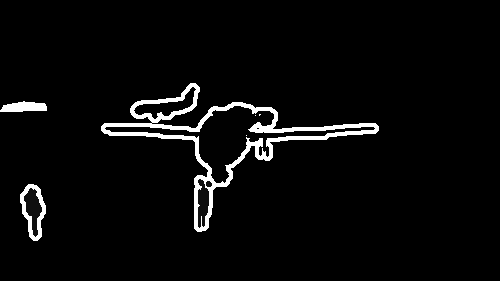

In [68]:
bg_text_features = bg_text_features.cuda()
fg_text_features = fg_text_features.cuda()
ori_image = Image.open(img_path)
ori_image

In [69]:
ori_height, ori_width = np.asarray(ori_image).shape[:2]

In [70]:
label_id_list = np.unique(ori_image)
label_id_list

array([  0,   1,  15, 255], dtype=uint8)

In [71]:
# Extract unique label IDs from the image and filter out unwanted values
label_id_list = (label_id_list - 1).tolist()
if 255 in label_id_list:
    label_id_list.remove(255)
if 254 in label_id_list:
    label_id_list.remove(254)
label_id_list

[0, 14]

In [72]:
# Get label names from class names
label_list = [new_class_names[int(lid)] for lid in label_id_list]
label_id_list = [int(lid) for lid in label_id_list]
label_list

['aeroplane', 'person with clothes,people,human']

In [73]:
img_i = img_i.unsqueeze(0)
h, w = img_i.shape[-2], img_i.shape[-1]

highres_cam_to_save = []
keys = []
cam_refined_list = []

To better understand why `text_features_temp` makes sense see "CLIP is Also an Efficient Segmenter: A Text-Driven Approach for Weakly Supervised Semantic Segmentation"

In [74]:
bg_features_temp = bg_text_features.cuda()  # [bg_id_for_each_image[im_idx]].to(device_id), not clear why needed (maybe clarity)
fg_features_temp = fg_text_features[label_id_list].cuda()
text_features_temp = torch.cat([fg_features_temp, bg_features_temp], dim=0)
text_features_temp.shape

torch.Size([27, 512])

In [75]:
input_tensor = [cam_fts, text_features_temp.cuda(), h, w]

In [76]:
cam_fts.shape

torch.Size([545, 1, 768])

Consider only first label

In [145]:
label = label_list[0]
label_index = new_class_names.index(label)
keys.append(label_index)
print(label, label_index)

aeroplane 0


In [146]:
targets = [ClipOutputTarget(label_list.index(label))] # label_list.index(label) != label_index 

- grad_cam in short: 
    - ``outputs = grad_cam.activations_and_grads(input_tensor, H, W)``
        - ``grad_cam.get_target_width_height`` to get `H` and `W` when `isinstance(input_tensor,list)`
        - register hooks on each layer in `target_layers` to save gradients and activations
        - return `encoder.forward_last_layer(input_tensor[0], input_tensor[1])` i.e. `outputs`
            - `encoder.forward_last_layer`:
                - 1: computes activations and attention weights of the last layer of the image features `encoder.visual.transformer.resblocks[-1](image_featues)`
                - 2: apply layer norm `encoder.visual.ln_post`, avg across patch tokens (ignore `cls` token) and project image features using `x @ encoder.visual.proj`
                - 3: normalize image and text features (just like CLIP)
                - 4: `logits_per_image` (cosine similarity as logits): `image_features @ text_features.t()` then softmax as introduced by "CLIP is also an efficient segmenter" to
                     make categories mutually exclusive 
                - 5: return `logits_per_image` and `attn_weight` computed in 1
        - ``logits_per_image == outputs[0]``
        - ``attn_weight_last == outputs[1]``
    - compute loss of the `logits_per_image[label]` to get cam
        - ``loss = sum([target(output[0]) for target, output in zip(targets, outputs)])`` # it shouldn't be an actual loss, it's just an activation (regular GradCAM)
        - propagate gradients: ``loss.backward(retain_graph = True)`` 
        - use `layer_grads.mean(axis=(2,3))` to compute feature importance i.e. `[N,E,H,W] -> [N,E]` importance of each patch 
        - compute weighted activations `weights[:,:,None,None] * activations -> [N,E,H,W]`
        - finally, compute the cam as `weighted_activations.sum(axis=1) -> [N,H,W]`
        - note: 
            - then cam is further processed and if computed using mutliple layers requires aggregations using `grad_cam.aggregate_multi_layer` and the final output is the variable `grayscale_cam`
            - this is a raw CAM which needs to be further refined using "Class-aware Attention-based Affinity (CAA)" as in "CLIP is also an efficient segmenter"; such refinement doesn't correspond to the one provided by the RFM in Frozen CLIP, which will be applied after the CAA and possible CRF (but not sure about this last part)

In [323]:
grayscale_cam, logits_per_image, attn_weight_last = grad_cam(input_tensor=input_tensor,
                                                             targets=targets,
                                                             target_size=None)
grayscale_cam.shape, logits_per_image.shape, attn_weight_last.shape

((1, 17, 32), torch.Size([1, 27]), torch.Size([1, 545, 545]))

Continue `perform_single_voc_cam`

In [80]:
grayscale_cam = grayscale_cam[0, :]

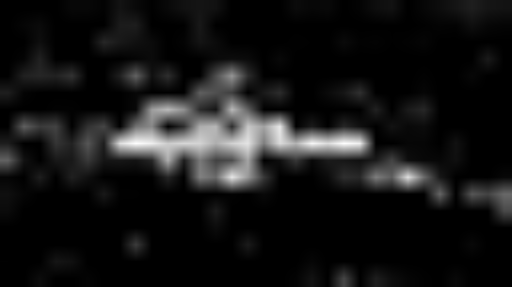

In [81]:
grayscale_cam_highres = cv2.resize(grayscale_cam, (w, h))
highres_cam_to_save.append(torch.tensor(grayscale_cam_highres))
ToPILImage()(grayscale_cam_highres)

Exaplin below how `grad_cam` computes ouput (TO DO)

In [ ]:
cam_refined_list, keys, w, h = perform_single_voc_cam(img_path, img_i, cam_fts, cam_attn, seg_attn,
                                                      bg_text_features, fg_text_features,
                                                      grad_cam, mode="val",
                                                      require_seg_trans=require_seg_trans)

In [ ]:
cam_dict = generate_cam_label(cam_refined_list, keys, w, h)
            
cams = cam_dict['refined_cam'].cuda()